In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from Functions import *

pd.set_option('display.max_columns', None)
pd.set_option("expand_frame_repr", False)
# pd.set_option('display.max_rows', None)

In [3]:
# Variable setup
range_in_s = (0, 300)  # range to be analysed in seconds [s]
allWells = ["A4", "A5", "B5", "C4", "C5", "D4", "D5"]
allElectrodes = [12, 13, 21, 22, 23, 24, 31, 32, 33, 34, 42, 43]
hcallDIVs = ['HDIV04', 'HDIV06', 'HDIV08', 'HDIV10', 'HDIV12', 'HDIV14', 'HDIV18', 'HDIV24',
           'CDIV04', 'CDIV06', 'CDIV08', 'CDIV10', 'CDIV12', 'CDIV14', 'CDIV18', 'CDIV24']
allDIVs = ['DIV04', 'DIV06', 'DIV08', 'DIV10', 'DIV12', 'DIV14', 'DIV18', 'DIV24',]

wellrainbow = np.array(["#FF0000", "#FF7F00", "#FFFF00", "#00FF00", "#0000FF", "#4B0082", "#9400D3"])

root = os.getcwd()
root


'C:\\Users\\Scorstje\\PycharmProjects\\MEApy'

In [4]:
# Spike dataframe construction

# reading in spike data from the MCS software as csv into a pandas dataframe
spkdf = pd.read_csv(f'{root}\\Data\\Hippocampus spk analysis.csv')
spkdf = spkdf.iloc[:, [1, 3, 6, 9]]  # Channel Label, Well Label, Experiment, Timestamp

# work around for this experiment, further experiments need to be done with DIV easily slicable from the experiment col
spkdf['DIV'] = ['DIV04' if x == '20230516_Hippocampus_pMEA_001' else
                'DIV06' if x == '20230518_Hippocampus_pMEA_001' else
                'DIV08' if x == '20230520_Hippocampus_pMEA_001' else
                'DIV10' if x == '20230522_Hippocampus_pMEA_001' else
                'DIV12' if x == '20230524_Hippocampus_pMEA_001' else
                'DIV14' if x == '20230526_Hippocampus_pMEA_001' else
                'DIV18' if x == '20230530_Hippocampus_pMEA_001' else
                'DIV24' if x == '20230605_Hippocampus_pMEA_001' else 'nan' for x in spkdf["Experiment"]]

# Create a DataFrame with all possible combinations of dc, wc, and ec
combos = pd.DataFrame([(dc, wc, ec) for dc in allDIVs for wc in allWells for ec in allElectrodes],
                      columns=["DIV", "Well Label", "Channel Label"])
missing_combos = pd.merge(combos, spkdf, on=["DIV", "Well Label", "Channel Label"], how="left") # Merge to find missing combinations
missing_combos = missing_combos[missing_combos.isnull().any(axis=1)]
spkdf = pd.concat([spkdf, missing_combos], ignore_index=True, sort=False)

del combos, missing_combos

active = 0
FFdf = pd.DataFrame(columns=["Electrode", "Well", "DIV", "FF", "Active"])  # Firing rate dataframe
for d in pd.unique(spkdf["DIV"]):  # DIV seperating
    day = spkdf.loc[spkdf['DIV'] == d, :]
    for w in pd.unique(spkdf["Well Label"]):  # Well seperation
        well = day.loc[day['Well Label'] == w, :]

        for e in pd.unique(well["Channel Label"]):  # change to right object
            elecdata = well.loc[well['Channel Label'] == e, :]
            spks_in_range = elecdata.loc[elecdata['Timestamp [µs]'] > range_in_s[0] * 1e6, :]  # needs to be done in one line
            spks_in_range = spks_in_range.loc[spks_in_range['Timestamp [µs]'] < range_in_s[1] * 1e6, :]  # ^

            spk_int = np.diff(spks_in_range['Timestamp [µs]'])
            if len(spk_int) > 10:
                active += 1

            list_row = [e, w, d, len(spks_in_range) / 300, active]  # NaNs are throwing errors
            active = 0
            FFdf.loc[len(FFdf)] = list_row  # adding row to the dataframe for graphing

del d, w, e, active, day, elecdata, list_row, spk_int, spks_in_range, well, spkdf

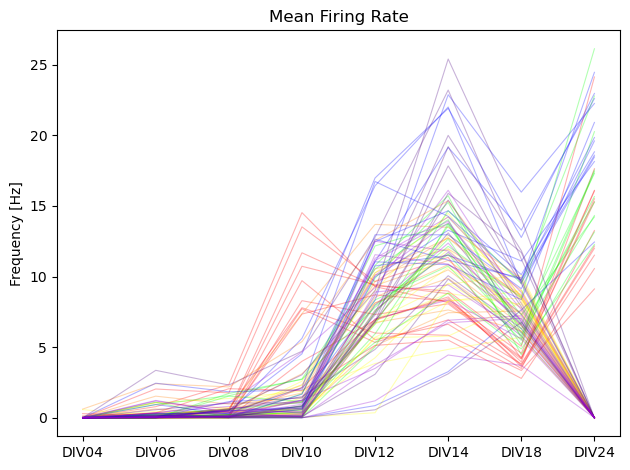

In [5]:
# Plotting Spks
plt.title("Mean Firing Rate")
plt.ylabel("Frequency [Hz]")
c = 0
for q in pd.unique(FFdf["Well"]):
    x = FFdf.loc[FFdf["Well"] == q]
    for _ in pd.unique(FFdf["Electrode"]):
        y = x.loc[FFdf["Electrode"] == _]
        plt.plot(y["DIV"], y["FF"], color=wellrainbow[c], alpha=0.3, lw=0.8)
    c += 1
plt.tight_layout()
plt.show()

del c, q, x, y

In [6]:
# Hippocampus burst data
# Changing experiment date to days in vitro and adding missing combinations of electrode, well and days that were inactive and therefore not in the data

bdf = pd.read_csv(f'{root}\\Data\\Hippocampus bursts analysis.csv')
bdf = bdf.iloc[:, [1, 3, 4, 6, 9, 10, 11, 12]]  # Channel Label, Well Label, Experiment, Start timestamp [µs], Duration [µs], Spike count, Spike Frequency [Hz]
bdf['End timestamp [µs]'] = bdf['Start timestamp [µs]'] + bdf['Duration [µs]']  # Adding End timestamp [µs]

# that's a neat piece of code
bdf['Experiment'] = ['DIV04' if x == '20230516_Hippocampus_pMEA_001' else
                     'DIV06' if x == '20230518_Hippocampus_pMEA_001' else
                     'DIV08' if x == '20230520_Hippocampus_pMEA_001' else
                     'DIV10' if x == '20230522_Hippocampus_pMEA_001' else
                     'DIV12' if x == '20230524_Hippocampus_pMEA_001' else
                     'DIV14' if x == '20230526_Hippocampus_pMEA_001' else
                     'DIV18' if x == '20230530_Hippocampus_pMEA_001' else
                     'DIV24' if x == '20230605_Hippocampus_pMEA_001' else'nan' for x in bdf["Experiment"]]

# Create a DataFrame with all possible combinations of dc, wc, and ec
combos = pd.DataFrame([(dc, wc, ec) for dc in allDIVs for wc in allWells for ec in allElectrodes],
                      columns=["Experiment", "Well Label", "Channel Label"])
missing_combos = pd.merge(combos, bdf, on=["Experiment", "Well Label", "Channel Label"], how="left") # Merge to find missing combinations
missing_combos = missing_combos[missing_combos.isnull().any(axis=1)]  # Isolate missing combinations based on NaN
bdf = pd.concat([bdf, missing_combos], ignore_index=True, sort=False)

del combos, missing_combos

In [7]:
# Hippocampus and cortex burst data
# Changing experiment date to days in vitro and adding missing combinations of electrode, well and days that were inactive and therefore not in the data

hcbdf = pd.read_csv(f'{root}\\Data\\MEA data.csv')
hcbdf = hcbdf.iloc[:, [1, 3, 4, 6, 9, 10, 11, 12]]  # Channel Label, Well Label, Experiment, Start timestamp [µs], Duration [µs], Spike count, Spike Frequency [Hz]
hcbdf['End timestamp [µs]'] = hcbdf['Start timestamp [µs]'] + hcbdf['Duration [µs]']  # Adding End timestamp [µs]

hcbdf['Experiment'] = ['HDIV04' if x == '20230516_Hippocampus_pMEA_001' else
                       'HDIV06' if x == '20230518_Hippocampus_pMEA_001' else
                       'HDIV08' if x == '20230520_Hippocampus_pMEA_001' else
                       'HDIV10' if x == '20230522_Hippocampus_pMEA_001' else
                       'HDIV12' if x == '20230524_Hippocampus_pMEA_001' else
                       'HDIV14' if x == '20230526_Hippocampus_pMEA_001' else
                       'HDIV18' if x == '20230530_Hippocampus_pMEA_001' else
                       'HDIV24' if x == '20230605_Hippocampus_pMEA_001' else
                       'CDIV04' if x == '20230516_Cortex_pMEA_001' else
                       'CDIV06' if x == '20230518_Cortex_pMEA_001' else
                       'CDIV08' if x == '20230520_Cortex_pMEA_001' else
                       'CDIV10' if x == '20230522_Cortex_pMEA_001' else
                       'CDIV12' if x == '20230524_Cortex_pMEA_001' else
                       'CDIV14' if x == '20230526_Cortex_pMEA_001' else
                       'CDIV18' if x == '20230530_Cortex_pMEA_001' else
                       'CDIV24' if x == '20230605_Cortex_pMEA_001' else 'nan' for x in hcbdf["Experiment"]]

# Create a DataFrame with all possible combinations of dc, wc, and ec
combos = pd.DataFrame([(dc, wc, ec) for dc in allDIVs for wc in allWells for ec in allElectrodes],
                      columns=["Experiment", "Well Label", "Channel Label"])
missing_combos = pd.merge(combos, hcbdf, on=["Experiment", "Well Label", "Channel Label"], how="left") # Merge to find missing combinations
missing_combos = missing_combos[missing_combos.isnull().any(axis=1)]  # Isolate missing combinations based on NaN
hcbdf = pd.concat([hcbdf, missing_combos], ignore_index=True, sort=False)

del combos, missing_combos

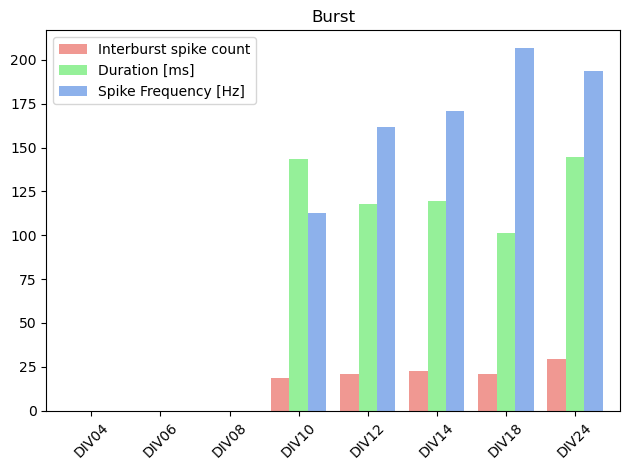

In [8]:
bdf['Duration [ms]'] = [x / 1e3 for x in bdf['Duration [µs]']]
bdf['Interburst spike count'] = bdf['Spike Count']

group = bdf.groupby(["Experiment"])[["Interburst spike count",
                                     "Duration [ms]",
                                     "Spike Frequency [Hz]"]].mean().plot(kind="bar", width=0.8, color=['#f09892',
                                                                                                        '#95f099',
                                                                                                        '#8db1eb'])
plt.title("Burst")
plt.xlabel("")
plt.ylim(bottom=0)
plt.xticks(rotation=45)
plt.tight_layout()

# plt.show()

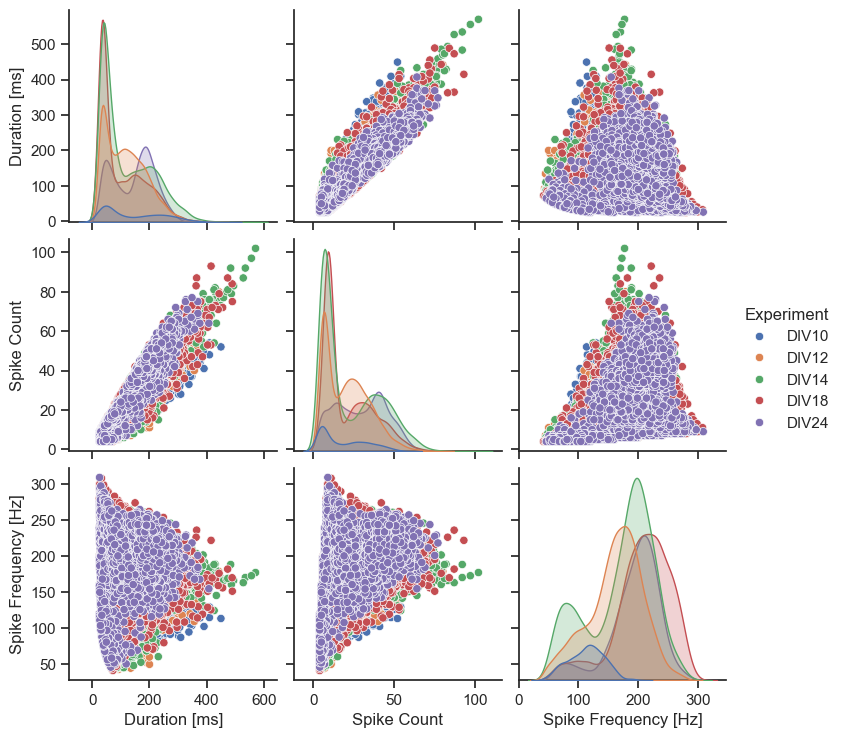

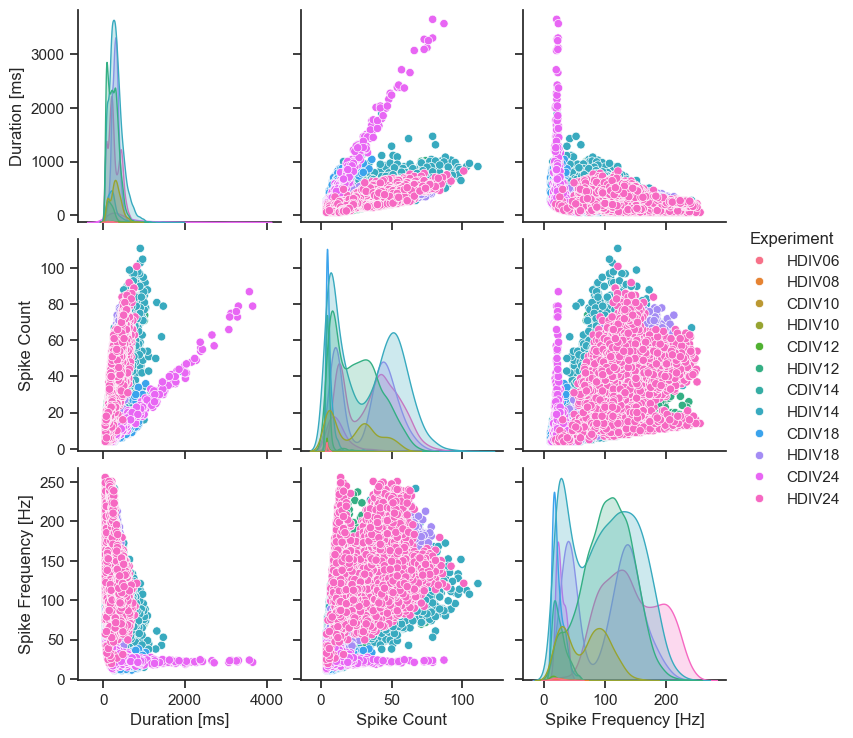

In [10]:
snsdf = bdf[["Experiment", "Duration [ms]", "Spike Count", "Spike Frequency [Hz]"]]
snsdf = snsdf.dropna()
hcbdf['Duration [ms]'] = [x / 1e3 for x in hcbdf['Duration [µs]']]
hcsnsdf = hcbdf[["Experiment", "Duration [ms]", "Spike Count", "Spike Frequency [Hz]"]]
hcsnsdf = hcsnsdf.dropna()
hcsnsdf = hcsnsdf.loc[lambda snsdf: hcsnsdf["Duration [ms]"] < 4000]
# snsdf = snsdf.loc[lambda snsdf: snsdf["Duration [ms]"] > 100]
# snsdf = snsdf.loc[lambda snsdf: snsdf["Spike Count"] > 20]

import seaborn as sns

sns.set_theme(style="ticks")
g = sns.pairplot(snsdf, hue="Experiment")
g = sns.pairplot(hcsnsdf, hue="Experiment")

# sns.jointplot(data=hcsnsdf, x="Duration [ms]", y="Spike Count", hue="Experiment", kind="hist")
# plt.show()